In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("er.ipynb")

# Random Graphs: The Erdős–Rényi and Stochastic Block Models

#### Authors:

v1.0 (2014 Fall) Rishi Sharma, Sahaana Suri, Kangwook Lee, Kannan Ramchandran<br />
v1.1 (2015 Fall) Kabir Chandrasekher, Max Kanwal, Kangwook Lee, Kannan Ramchandran<br />
v1.2 (2016 Fall) Kabir Chandrasekher, Tony Duan, David Marn, Ashvin Nair, Kangwook Lee, Kannan Ramchandran <br />
v1.3 (2018 Spring) Tavor Baharav, Kaylee Burns, Gary Cheng, Sinho Chewi, Hemang Jangle, William Gan, Alvin Kao, Chen Meng, Vrettos Muolos, Kanaad Parvate, Ray Ramamurti <br />
v1.4 (2018 Fall) Raghav Anand, Kurtland Chua, Payam Delgosha, William Gan, Avishek Ghosh, Justin Hong, Nikunj Jain, Katie Kang, Adarsh Karnati, Eric Liu, Kanaad Parvate, Ray Ramamurti, Amay Saxena, Kannan Ramchandran, Abhay Parekh <br />
v2.0 (2022 Spring) Sohom Paul, Clark Wang, Catherine Huang <br />
v2.1 (2022 Fall) Axel Li, Reina Wang, Andy Dong, Kannan Ramchandran <br />
v3.0 (2023 Spring) Reina Wang, Thomas Courtade <br />
v3.1 (2024 Fall) Tianhao Wu <br />
v3.2 (2025 Spring) Lance Mathias <br />

## Question 1 -- The Erdős–Rényi Model

To begin the lab, we explore random graphs, introduced by [Erdős and Rényi](http://www.renyi.hu/~p_erdos/1959-11.pdf). Note that you don't need prior knowledge of random graphs for this lab.

In the Erdős-Rényi model, we use the notation $\operatorname{G}(n,p)$ to denote a random graph that has $n$ nodes and probability $p$ of an edge between each pair of nodes. More precisely, for each pair of nodes, we flip a biased coin with probability $p$ of heads - if it lands heads, we add an edge between those nodes. All these coin flips are independent. This simple model has many fascinating properties and has been extensively studied in probability theory, computer science and statistical physics. For example, as we increase $p$ from 0 to 1, the random graph undergoes several phase transitions where its structural properties change dramatically.

This lab requires [Python 3.7+](https://www.python.org/downloads/) and the [NetworkX](http://networkx.github.io/documentation/stable/install.html), which comes by default with Anaconda. You can check your Python version using the following cell and install NetworkX via `!pip install networkx`; you may need to restart the Jupyter kernel after installing NetworkX.

If either cell fails on your local machine, you can also navigate to [colab.research.google.com](colab.research.google.com) and upload this file to run this notebook remotely.

In [3]:
!pip install networkx -q

In [4]:
import sys
assert sys.version_info.major == 3, "Please use Python3!"
assert sys.version_info.minor >= 7, "This lab requires Python 3.7 or higher."

We provide the following `Graph` class and a function written to draw graphs for you. You should know how to use `draw_graph`, but you don't really need to know how it works. Play around with it and look at those pretty graphs :)

In [5]:
%matplotlib inline
from typing import Iterable, Tuple, Set

import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [6]:
Vertex = int

class Graph:
    def __init__(self, num_vertices: int):
        self.vertices = [Vertex(i) for i in range(num_vertices)]
        self.adjacency_lists = dict()
        for v in self.vertices:
            self.adjacency_lists[v] = set()

    def get_neighbors(self, vertex: Vertex):
        if vertex not in self.vertices:
            raise ValueError(f"Given vertex {vertex} not found in vertex set.")
        return self.adjacency_lists[vertex]

    def add_edge(self, v1: Vertex, v2: Vertex):
        if v1 not in self.vertices or v2 not in self.vertices:
            raise ValueError(
                f"One of given vertices {v1} or {v2} not found in vertex set."
            )
        self.adjacency_lists[v1].add(v2)
        self.adjacency_lists[v2].add(v1)

    def add_edges(self, edge_list: Iterable[Tuple[Vertex, Vertex]]):
        for v1, v2 in edge_list:
            self.add_edge(v1, v2)

In [7]:
def draw_graph(
    graph: Graph, 
    graph_layout='shell',
    node_size=3200, 
    node_color='blue',
    node_alpha=0.3,
    node_text_size=24,
    edge_color='blue',
    edge_alpha=0.3,
    edge_tickness=2,
    text_font='sans-serif',
):
    nx_graph = nx.Graph()
    for v1 in graph.vertices:
        nx_graph.add_node(v1)
        for v2 in graph.get_neighbors(v1):
            nx_graph.add_edge(v1, v2)   
    if graph_layout == 'spring':
        graph_pos = nx.spring_layout(nx_graph)
    elif graph_layout == 'spectral':
        graph_pos = nx.spectral_layout(nx_graph)
    elif graph_layout == 'random':
        graph_pos = nx.random_layout(nx_graph)
    else:
        graph_pos=nx.shell_layout(nx_graph)
    nx.draw_networkx_nodes(
        nx_graph, 
        graph_pos, 
        node_size=node_size, 
        alpha=node_alpha,
        node_color=node_color
    )
    nx.draw_networkx_edges(
        nx_graph,
        graph_pos,
        width=edge_tickness,
        alpha=edge_alpha,
        edge_color=edge_color
    )
    nx.draw_networkx_labels(
        nx_graph,
        graph_pos,
        font_size=node_text_size,
        font_family=text_font
    )
    plt.show()

In [9]:
def find_connected_component(graph: Graph, starting_node: Vertex) -> Set[Vertex]:
    """
    Returns a set of vertices the graph connected to a starting node.
    """
    visited = set()
    frontier = list()
    frontier.append(starting_node)
    visited.add(starting_node)
    while frontier:
        curr = frontier.pop()
        for adjacent in graph.get_neighbors(curr):
            if adjacent not in visited:
                visited.add(adjacent)
                frontier.append(adjacent)
    return visited

def connected_components(graph: Graph) -> Iterable[Set[Vertex]]:
    """
    Returns a list of sets containing the connected components of the graph.
    """
    components = []
    seen = set()
    for v in graph.vertices:
        if v not in seen:
            component = find_connected_component(graph, v)
            components.append(component)
            seen = seen.union(component)
    return components

def component_sizes(graph: Graph) -> Iterable[int]:
    """
    Returns a list of sizes of the connected components of the graph.
    """
    return [len(component) for component in connected_components(graph)]

def largest_component_size(graph: Graph) -> int:
    """
    Returns the size of the largest connected component of the graph.
    """
    return max(component_sizes(graph))

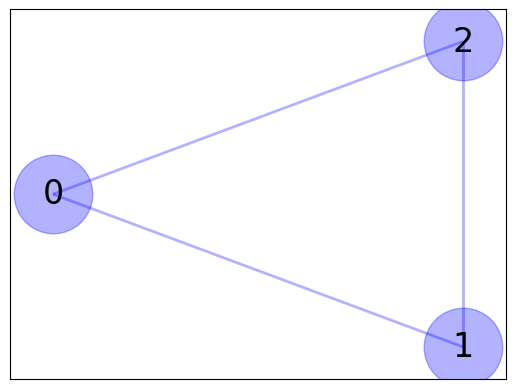

In [10]:
graph = Graph(num_vertices=3)
edge_list = [(0, 1), (1, 2), (0, 2)]
graph.add_edges(edge_list)
draw_graph(graph)

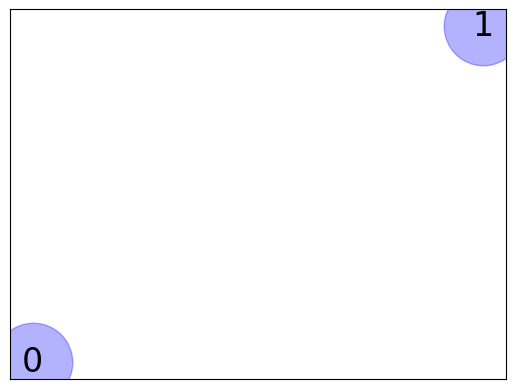

In [11]:
graph = Graph(num_vertices=2)
draw_graph(graph)

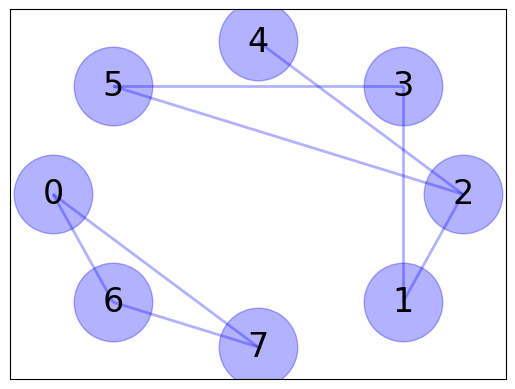

Nodes reachable from node 0: {0, 6, 7}
Nodes reachable from node 1: {1, 2, 3, 4, 5}
Connected components: [{0, 6, 7}, {1, 2, 3, 4, 5}]
Component sizes: [3, 5]
Largest component size: 5


In [12]:
graph = Graph(num_vertices=8)
edge_list = [(1, 2), (1, 3), (2, 4), (2, 5), (3, 5), (0, 6), (6, 7), (0, 7)]
graph.add_edges(edge_list)
draw_graph(graph)
print("Nodes reachable from node 0:", find_connected_component(graph, 0))
print("Nodes reachable from node 1:", find_connected_component(graph, 1))
print("Connected components:", connected_components(graph))
print("Component sizes:", component_sizes(graph))
print("Largest component size:", largest_component_size(graph))

We want to create a function that, given the number of nodes in a graph, will randomly generate edges between nodes. That is, we want to construct a random graph following the Erdős–Rényi model.

### Part 1a. 
Fill out the following function to create an Erdős–Rényi random graph $\operatorname{G}(n,p)$.

In [13]:
def G_ER(n: int, p: float) -> Graph:
    """
    Create a random graph G(n, p).
    Consider using `graph.add_edge()` and `np.random.rand()`.
    """
    graph = Graph(n)
    for u, v in itertools.combinations(graph.vertices, 2):
        if np.random.rand() < p: graph.add_edge(u, v)
    return graph

Make sure you can see all nodes from 0 to 9 in the graph below -- if not, check your code!

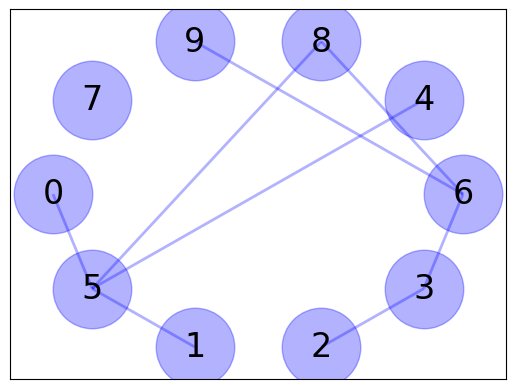

In [26]:
graph = G_ER(10, 0.25)
draw_graph(graph)

In [15]:
grader.check("1a")

1a results: All test cases passed!

Now, let's run a few experiments to examine the properties of an Erdős - Rényi random graph.

#### Part 1b.

First, for each value of p below, generate 100 ER graphs with $n = 100$ vertices, and find the empirical probability of an ER graph being fully connected. 

Then, generate a plot comparing the value of p to the empirical probability of a graph being fully connected. We recommend using a log scale for the x-axis.

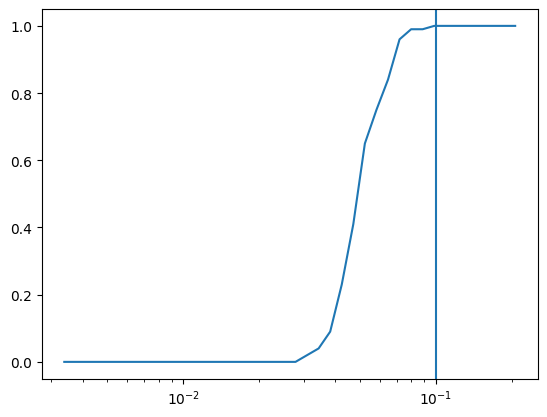

In [ ]:
import math

p_vals = [0.9**i for i in range(15, 55)]
num_trials = 100 # Try 100 for better accuracy
n = 100

def prob_fully_connected(n: int, p: float, num_trials: int) -> float:
    successes = 0
    for _ in range(num_trials):
        g = G_ER(n, p)
        if largest_component_size(g) == n:
            successes += 1
    return successes / num_trials

empirical_probs = []
"""Please store your empirical probabilities in the list empirical_probs, otherwise the tests will fail!"""
for p in p_vals:
    empirical_probs.append(prob_fully_connected(n, p, num_trials))  

assert len(empirical_probs) == len(p_vals)

# Plot the empirical probabilities against values of p. We recommend using a log scale for the x-axis.
# In addition, plot a vertical line at the threshold where the graph is connected with high probability
# (you will use this for the next problem).

# Enter your code here. 
plt.plot(p_vals, empirical_probs)
thresh = math.log(n)/n
plt.axvline(x=thresh)
plt.xscale('log')
plt.show()

In [34]:
grader.check("1b")

1b results: All test cases passed!

#### What is the threshold in which with high probability, the graph is connected? In your graph above, draw a vertical line at the threshold.

Hint: Look at the graph and plot the curve in the graph.

In [ ]:
def connectivity_threshold(n: int) -> float:
    """
    Returns the connectivity threshold for a random graph with n vertices.
    """
    ...

# Fill in the empirical threshold that you've calculated here, given n = 100 vertices. Format as 4 decimals, ex: 0.1234
empirical_connectivity_threshold = ...

In [ ]:
grader.check("1b-thresh")

#### Part 1c.
Now, for each value of $p$ below, generate 100 ER graphs with n=100 vertices, and find the empirical probability of an ER graph having no connected components of size larger than $\log(n)$. 

Then, plot the empirical probabilities against values of $p$. We recommend using a log scale for the x-axis.

In [ ]:
p_vals = [0.9**i for i in range(20, 65)]
num_trials = 100
n = 100
logn = np.log2(n)

def prob_no_large_component(n: int, p: float, num_trials: int) -> float:
    ...

empirical_probs = []
"""Please store your empirical probabilities in the list empirical_probs, otherwise the tests will fail!"""
for p in p_vals:
    empirical_probs.append(prob_no_large_component(n, p, num_trials))

assert len(empirical_probs) == len(p_vals)

# Plot the empirical probabilities against values of p. We recommend using a log scale for the x-axis.
...

In [ ]:
grader.check("1c")

#### From your graph, what is the threshold in which with high probability, the graph has no connected components of size larger than $\operatorname{O}(\log(n))$? Draw a vertical line at the threshold.

Hint: Take a look at the value of n*p, plot the curve in the graph to check! 

In [ ]:
def large_cc_threshold(n: int) -> float:
    """
    Returns the connectivity threshold for a random graph with n vertices.
    """
    ...

empirical_large_cc_threshold = ...

In [ ]:
grader.check("1c-thresh")

Cool! Now we've experimentally verified several results of the Erdős–Rényi graph. 

Isn't it neat that you can rigorously formalize this kind of qualitative behavior of a graph, and then clearly see them in simulation? 

## Question 2 -- The Stochastic Block Model


So far we've discussed the Erdős–Rényi model of a random graph $G(n,p)$. There are extensions that are better, more realistic models in many situations.

As a motivating example, consider the graph formed by friendships of Berkeley students and Stanford students on Facebook.  The probability of a friendship between two students both attending UC Berkeley is much higher than the probability that a student from UC Berkeley is friends with a student from Stanford. In the Erdos-Renyi model, however, the two edges formed by these friendships have the same probability!

In this section, we will explore communities such as the following:

<!-- <img src="https://data.graphstream-project.org/talks/CSSS2012/media/Community_Structure2.jpg" width=300 /> -->
<img src="images/community_structure_visualization.jpeg" width=300>

How will we do this? Use the <b>stochastic block model</b> (let's call it SBM) -- we have graphs of $G(n,p,q)$ (for simplicity, let's assume $n$ is even and $p>q$). 

In this model, we have two "communities" each of size $\frac{n}{2}$ such that the probability of an edge existing between any two nodes within a community is $p$ and the probability of an edge between the two communities is $q$.

<!-- <img src="http://i.imgur.com/JAPqQNf.png" width="400" height="400" /> -->
<img src="images/sbm_before_recovery.png" width="450">

Our goal will be to recover the original communities. For this example, the result would look something like:

<!-- <img src="http://i.imgur.com/Ec2Xehs.png" width="450" height="450" /> -->
<img src="images/sbm_after_recovery.png" width="450">

Let's begin by defining a function to generate graphs according to the stochastic block model.

### 2a. Fill out the following function to create a graph $G(n,p,q)$ according to the SBM.


**Important Note**: make sure that the first $\frac{n}{2}$ nodes are part of community A and the second $\frac{n}{2}$ nodes are part of community B.

We will be using this assumption for later questions in this lab, when we try to recover the two communities.

In [ ]:
def G_SBM(n: int, p: float, q: float) -> Graph:
    """
    Create a copy of G(n, p, q) with 2 community where the first 
    n/2 nodes are part of the first community and the second n/2 
    nodes are part of second community.

    Consider using the provided graph.add_edge() function.
    """
    assert n % 2 == 0
    assert p > q
    graph = Graph(n)
    mid = n // 2
    communityA = graph.vertices[:mid]
    communityB = graph.vertices[mid:]
    for u, v in itertools.combinations(communityA, 2):
        ...
    for u, v in itertools.combinations(communityB, 2):
        ...
    for u, v in itertools.product(communityA, communityB): 
        ...
    return graph

In [ ]:
graph = G_SBM(20, 0.6, 0.05)
plt.figure(figsize=(12, 12))
draw_graph(graph,graph_layout='spring')

In [ ]:
grader.check("2a")

Now recall the previous example:

<img src="http://i.imgur.com/Ec2Xehs.png" width="450"/>


How did we determine the most likely assignment of nodes to communities?

An intuitive approach is to find the **min-bisection** -- the split of $G$ into 2 groups each of size $\frac{n}{2}$ that has the *minimum total edges crossing the partition*. The intuition here is that we want to **minimize** friendships across communities, as under our assumptions, **p > q** so it is more likely to be friends within a community than across. Notice, if we assume that **p < q**, then we would have been interested in the max-bisection.

It turns out that this approach is the optimal method of recovering community assignments in terms of maximizing over all possible partitions the probability of seeing the graph $G$ given a community partition. This is called the Maximum Likelihood Estimate (MLE) of the partition given the graph $G$. It is an interesting exercise to prove this which you can try if you would like. You will prove a variant of this result in homework when we go over Maximum Likelihood Estimation and Maximum A Posteriori Estimation.

### 2b. Given a graph $G(n,p,q)$, write a function to find the maximum likelihood estimate of the two communities.

In [ ]:
def count_crossing_edges(community: Set[Vertex], graph: Graph) -> int:
    """
    Find the number of edges cross the partition between this community 
    and the rest of the vertices in the graph.
    """
    other = set(graph.vertices).difference(set(community))
    num_crossings = 0
    ...
    return num_crossings

def mle(graph: Graph) -> Iterable[Vertex]:
    """
    Tries every possible way to partition the graph into communities of equal
    size and returns the partition with the fewest number of edges crossing 
    between the communites.
    """
    possible_comms = set(
        itertools.combinations(graph.vertices, len(graph.vertices)//2)
    )
    ...

Here's a quick test for your MLE function -- check that the resulting partitions look okay!

In [ ]:
graph = G_SBM(10, 0.6, 0.05)
plt.figure(figsize=(8, 8))
draw_graph(graph,graph_layout='spring')

In [ ]:
community = mle(graph)
print('The community found is the nodes', community)

In [ ]:
grader.check("2b")

Now recall that important note from earlier -- in the graphs we generate, the first $\frac{n}{2}$ nodes are from community A and the second $\frac{n}{2}$ nodes from community B.

We can therefore test whether or not our MLE method accurately recovers these two communities from randomly generated graphs that we generate. In this section we will simulate the probability of exact recovery using MLE.

### 2c. Write a function to simulate the probability of exact recovery through MLE given $n,p,q$. 

In [ ]:
def prob_recovery(n: int, p: float, q: float) -> float:
    """
    Simulate the probability of exact recovery through MLE.
    Use 100 samples.
    """
    ...

Here's a few examples to test your simulation:

In [ ]:
print("P(recovery) for n=10, p=0.5, q=0.05 --", prob_recovery(10, 0.5, 0.05)) # usually recovers
print("P(recovery) for n=10, p=0.92, q=0.06 --", prob_recovery(10, 0.92, 0.06))  # almost certainly recovers
print("P(recovery) for n=10, p=0.12, q=0.06 --", prob_recovery(10, 0.12, 0.06))  # almost certainly fails

In [ ]:
grader.check("2c")

### 2d (Optional). Can you find a threshold on $(p, q, n)$ for exact recovery through MLE?

It turns out that there is a threshold on $(p,q,n)$ for a phase transition which determines whether or not the communities can be recovered using MLE.

This part of the lab is meant to be open-ended. You should use the code you've already written to help arrive at an expression for threshold in the form

$$f(p,q,n) > 1$$

After this threshold, can almost recover the original communities in the SBM.

Define the following:
$$\alpha=p\frac{n}{\log n}$$
$$\beta=q\frac{n}{\log n}$$

The threshold for exact recovery occurs at
$$\frac{\alpha + \beta}{2} - \sqrt{\alpha\beta} > 1$$

Those curious are encouraged to check out the paper [Exact Recovery in the Stochastic Block Model](http://arxiv.org/pdf/1405.3267.pdf) (Abbe, Bandeira, Hall)

Congratulations! You've reached the end of the lab.

## References

1. https://www.udacity.com/wiki/creating-network-graphs-with-python

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

We recommend you to direct submit the .ipynb file after you finish the lab. For this lab, no self-grade is required. If this command errors, save and submit this .ipynb file regardless.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)